## Classification with Gaussian Processes

References: 
* MLAPP (Sec. 15.3)
* GPs for Machine Learning (Rasmussen & Williams, 2006)
* Section on GPs from https://github.com/krasserm/bayesian-machine-learning

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
np.random.seed(70)

### Dataset

Initially we start with a nonlinearly separable dataset for binary classification generated through sklearn. Each input has 2 features as shown below:

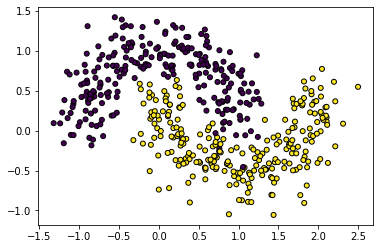

In [11]:
from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=500, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=25, edgecolor='k')

In [12]:
# Shuffle & split dataset
def shuffleSplit(X, Y):
    """Randomly shuffles and splits data into 80% train & 20% test set"""
    N = X.shape[0]
    perm = np.random.permutation(range(N))
    xTrain = X[perm, :][:int(0.8*N), :]
    yTrain = Y[perm][:int(0.8*N)]
    xTest = X[perm, :][int(0.8*N):, :]
    yTest = Y[perm][int(0.8*N):]

    return xTrain, yTrain, xTest, yTest

In [13]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

We use a squared exponential kernel $k(\mathbf{x_i, x_j)} = \rho^2 e^{-\frac{||\mathbf{x}_i-\mathbf{x}_j||^2}{2l^2}}$

In [14]:
def getKernel(rho, l, X):
    """Creates the kernel matrix using rho (variance parameter) and l (smoothness parameter)"""
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i][j] = (rho**2)*(np.exp(-np.linalg.norm((X[i, :] - X[j, :]), 2)**2/(2*l**2)))

    K += 10**(-4)*np.identity(X.shape[0]) # for numerical stability & inversion

    return K

In [15]:
def getPrior(K):
    """Computes the prior of the GP by drawing a random sample from N(0, K)"""
    return np.random.multivariate_normal(np.zeros(K.shape[0]), K)

### Posterior
We use a bernoulli likelihood and a gaussian process prior, which are non-conjugate. This makes the log posterior $\log p(\mathbf{f}|\mathbf{y}) = \log p(\mathbf{y}|\mathbf{f})-\frac{1}{2}\log |K|-\frac{N}{2}\log 2\pi - \frac{1}{2}\mathbf{f}^T\mathbf{K}^{-1}\mathbf{f}$ intractable, so we use the laplace approximation to compute it. 

The result will be a gaussian with mean equal to the MAP estimate and covariance matrix as the hessian. 

We use Newton's method to get the MAP estimate $\hat{\mathbf{f}}$. This algorithm is called Iteratively Reweighted Least Squares (IRLS). A full derivation is provided in MLAPP Sec. 15.3.1 and Sec. 3.4.1 of Rasmussen & Williams' book. 

Also since $p(\mathbf{y}|\mathbf{f}) = \sum y_n\log\sigma(f_n)+(1-y_n)\log(1-\sigma(f_n))$, we can write $\nabla\log p(\mathbf{y}|\mathbf{f}) = \{y_1 - \sigma(f_1), ... , y_N-\sigma(f_N)\}$. 

Then $\mathbf{W} = -\nabla^2\log p(\mathbf{y}|\mathbf{f}) = diag\{\sigma(f_1)(1-\sigma(f_1), ... , \sigma(f_N)(1-\sigma(f_N)\}$. 

Then clearly the hessian of the negative of the log posterior $p(\mathbf{f}|\mathbf{y})$ is given by $\mathbf{H} = \mathbf{W}+\mathbf{K}^{-1}$.

In the function below we modify these computations for numerical stability as specified in Rasmussen & Williams (Sec. 3.4.3).
To summarize such changes we make sure we don't compute inverses directly as much as possible (solve systems of equations instead), and use the cholesky/square root decomposition of of positive definite matrices to simplify such computations

In [16]:
def getPosteriorEfficient(K, Y):
    """
       Computes the GP Posterior's mean and variance using the laplace approximation. 
       This method is numerically efficient and ensures all computations are stable as per Section 3.4.3 of "GPs for Machine Learning" (Rasmussen & Williams, 2006)
    """
    f = np.zeros(Y.shape[0])
    diff = 1
    while diff > 10**(-10):
        W = np.diag(np.multiply(sigmoid(f), (1-sigmoid(f))))
        B = np.identity(Y.shape[0]) + np.sqrt(W) @ K @ np.sqrt(W)
        L = np.linalg.cholesky(B)
        b = W.dot(f) + Y - sigmoid(f)

        temp = np.linalg.solve(L, np.sqrt(W) @ K @ b)
        a = b - np.sqrt(W).dot(np.linalg.solve(L.T, temp))
        f_new = K.dot(a)

        diff = np.linalg.norm(f_new - f, 2)
        f = f_new
    
    H = W+np.linalg.inv(K)

    return f, H

### Marginal Likelihood
This is given by $\log p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2}\hat{\mathbf{f}}^T\mathbf{K}^{-1}\hat{\mathbf{f}}+\log p(\mathbf{y}|\hat{\mathbf{f}}) - \frac{1}{2}\log|\mathbf{K}||\mathbf{K}^{-1}+\mathbf{W}|$ (Rasmussen & Williams, 2006)

For numerical stability we compute $-\frac{1}{2}\hat{\mathbf{f}}^T\mathbf{K}^{-1}\hat{\mathbf{f}} + \sum y_n\log\sigma(\hat{f}_n)+(1-y_n)\log(1-\sigma(\hat{f}_n)) - \frac{1}{2}\log |\mathbf{I}_N + \mathbf{W}^{\frac{1}{2}}\mathbf{KW}^{\frac{1}{2}}|$ instead. $\mathbf{W}$ is a PD diagonal matrix so we can make this sort of modification,

In [17]:
def computeNegLogMarginal(params, X, Y):
    """
        Inputs: params vector containing 'rho' and 'l' (kernel params), train input data, train output data
        Returns: negative log marginal likelihood
    """
    K = getKernel(params[0], params[1], X)
    f, _ = getPosteriorEfficient(K, Y)
    W = np.diag(np.multiply(sigmoid(f), (1-sigmoid(f))))

    logMarginal = -0.5*np.dot(f.T, np.linalg.inv(K).dot(f)) + \
                np.sum(np.multiply(Y, np.log(sigmoid(f)))+np.multiply(1-Y, np.log(1-sigmoid(f)))) - \
                0.5*np.log(np.linalg.det(np.identity(K.shape[0])+np.sqrt(W).dot(K).dot(np.sqrt(W))))
    
    return -logMarginal

Now we can train the hyperparameters $\rho$ and $l$ (starting with initial values of $\rho=1$ and $l=1$) with L-BFGS:
(this can take a couple of minutes)

In [ ]:
xTrain, yTrain, xTest, yTest = shuffleSplit(X, Y)
optimalParams = scipy.optimize.minimize(computeNegLogMarginal, [1, 1], args=(xTrain, yTrain), bounds=((10**(-3), None), (10**(-3), None))) 

In [19]:
print('Initial params: rho = 1, l = 1')
print('Negative Log Marginal Likelihood with initial params = {}'.format(computeNegLogMarginal([1, 1], xTrain, yTrain)))
print('Optimized params: rho = {}, l = {}'.format(optimalParams.x[0], optimalParams.x[1]))
print('Negative Log Marginal Likelihood with optimized params = {}'.format(computeNegLogMarginal(optimalParams.x, xTrain, yTrain)))

Initial params: rho = 1, l = 1
Negative Log Marginal Likelihood with initial params = 121.83004536079787
Optimized params: rho = 13.891693514457174, l = 0.7214340179468245
Negative Log Marginal Likelihood with optimized params = 38.788987423406155


Compute posterior for our chosen dataset and visualize:

In [20]:
rho, l = optimalParams.x
K = getKernel(rho, l, xTrain)
gpPrior = getPrior(K)

# Compute posterior with initial hyperparameters
initK = getKernel(1, 1, xTrain)
initPosteriorMean, initPosteriorSigma = getPosteriorEfficient(initK, yTrain)

# Compute posterior for optimized hyperparameters
gpPosteriorMean, gpPosteriorSigma = getPosteriorEfficient(K, yTrain)

The contours represent regions where the posterior gives high and low weight - these can help us understand which class will be predicted in which region later. Clearly the version with optimized hyperparameters is able to capture the modes in the data in a better way:



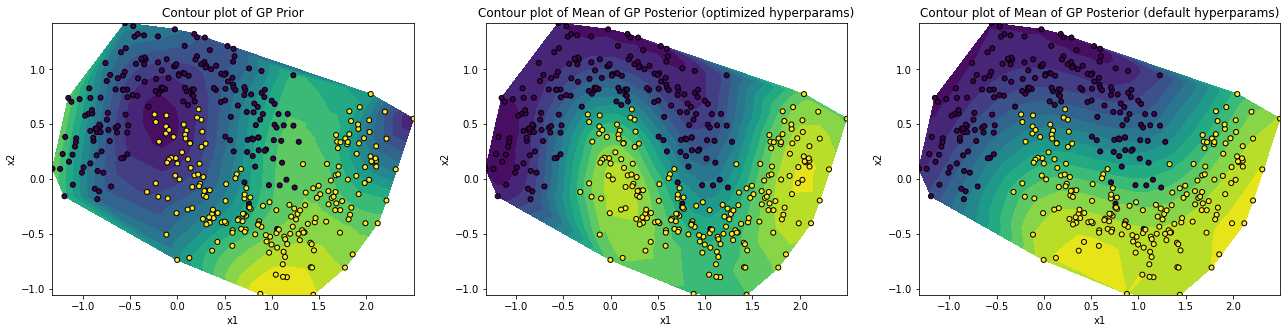

In [21]:
fig = plt.figure(figsize=(22, 5))
plt.subplot(131)
plt.tricontourf(xTrain[:, 0], xTrain[:, 1], gpPrior, levels=15)
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=25, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot of GP Prior')

plt.subplot(132)
plt.tricontourf(xTrain[:, 0], xTrain[:, 1], gpPosteriorMean, levels=15)
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=25, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot of Mean of GP Posterior (optimized hyperparams)')

plt.subplot(133)
plt.tricontourf(xTrain[:, 0], xTrain[:, 1], initPosteriorMean, levels=15)
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=25, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot of Mean of GP Posterior (default hyperparams)')

print('The contours represent regions where the posterior gives high and low weight - these can help us understand which class will be predicted in which region later. \
Clearly the version with optimized hyperparameters is able to capture the modes in the data in a better way:\n')

### Posterior Predictive
Using the posterior we can compute (full derivation in MLAPP 15.3.1.2.)

$p(f^*|\mathbf{x}_*, \mathbf{X}, y) = \mathcal{N}(f^*|\mu, V)$ 

where $\mu = \mathbf{k}_*^T\mathbf{K}^{-1}\hat{\mathbf{f}}$ and $V = k(\mathbf{x}^*, \mathbf{x}^*) - \mathbf{k}_*^T(\mathbf{K}+\mathbf{W}^{-1})\mathbf{k}_*$. Here $\hat{\mathbf{f}}$ is the posterior mean)

**For numerical stability:**

At the optima $\nabla \log p(\mathbf{\hat{f}}|\mathbf{y}) = 0$ so $\nabla \log p(\mathbf{y}|\mathbf{\hat{f}}) = \mathbf{K^{-1}\hat{f}}$. Then $\mu = {\mathbf{k}_*}^T\nabla \log p(\mathbf{y}|\mathbf{\hat{f}})$.

Also we can rewrite $V$ as $\rho^2 - \mathbf{k}_*^T\mathbf{W}^{\frac{1}{2}}(\mathbf{LL^T})^{-1}\mathbf{W}^{\frac{1}{2}}\mathbf{k_*} = \mathbf{v}^T\mathbf{v}$, where $\rho$ is the variance parameter of the squared exponential kernel. We have used the cholesky decomposition and the fact that $\mathbf{W}$ is a diagonal matrix.

We can use these expressions to compute the PPD:
$\pi^* = p(y^*=1|\mathbf{x}_*, \mathbf{X}, \mathbf{y})\approx \int \sigma(f^*)p(f^*|\mathbf{x}_*, \mathbf{X}, y)df^* = \int \sigma(f^*)\mathcal{N}(f^*|\mu, V)df^* \approx \sigma\left(\frac{\mu}{\sqrt{1+\frac{\pi V}{8}}}\right)$

The sigmoid-normal integral is approximated by a sigmoid function.

In [22]:
def getPosteriorPredictiveEfficient(xTest, f, X, Y, K, rho, l):
    """
        Computes the PPD over a test dataset
        Input: test inputs, posterior mean, train input data, train output data, kernel matrix, kernel variance param, kernel length param
        Returns: Vector 'preds' containing means, variances, and final probabilities of all test inputs
    """
    
    W = np.diag(np.multiply(sigmoid(f), (1-sigmoid(f))))
    B = np.identity(Y.shape[0]) + np.sqrt(W) @ K @ np.sqrt(W)
    L = np.linalg.cholesky(B)

    preds = []
    for j in range(len(xTest)):
        kStar = np.array([(rho**2)*(np.exp(-np.linalg.norm((xTest[j, :] - X[i, :]), 2)**2/(2*l**2))) for i in range(X.shape[0])])
        fStarMean = kStar.T.dot(Y - sigmoid(f))
        v = np.linalg.solve(L, np.sqrt(W).dot(kStar))
        fStarVar = rho**2- v.T.dot(v)
        
        # Approximate sigmoid(z)N(z|fStarMean, fStarVar) integral with a sigmoid approximation as per MLAPP section 15.3.1.2
        piStar = sigmoid(fStarMean/np.sqrt(1+(np.pi*fStarVar/8)))
        preds.append([fStarMean, fStarVar, piStar])

    return np.array(preds)

Now compute predictive probabilities over a discrete grid in $(x_1, x_2)$ space and visualize

In [23]:
xs = np.linspace(-1.5, 2.5, 40)
ys = np.linspace(-1, 1.5, 40)
grid = np.array([[i, j] for i in xs for j in ys])
preds = getPosteriorPredictiveEfficient(grid, gpPosteriorMean, xTrain, yTrain, K, rho, l)

Performance on Test Set: 100 points classified correctly out of 100 total points

The contours are computed by finding the PPD for each point in the grid, so they are an accurate representation of the model's understanding.
Comparing the three figures on the bottom, we can see that the model performs well on the test set considering the original data.
The plot of the posterior mean captures modes in the feature space - this is similar to the contour plots of the posteriors but it is more complete since we have used the entire grid.
The variance plot helps us see regions where the model is unsure - in this case it seems to higher in regions which have less training data available, which makes sense.


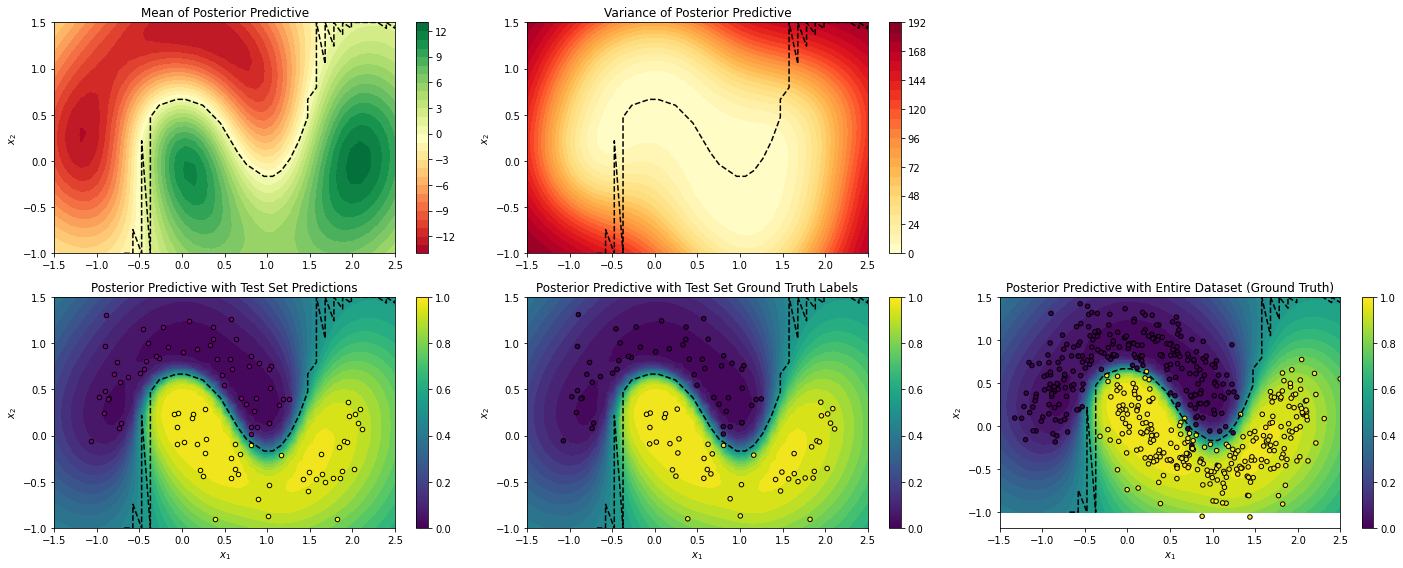

In [24]:
plt.figure(figsize=(20, 8))

plt.subplot(231)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 0], levels=25, cmap='RdYlGn')
boundary = grid[np.where((preds[:, 2] > 0.44) & (preds[:, 2] < 0.56))]
plt.plot(boundary[:, 0], boundary[:, 1], '--', c='black')
plt.colorbar()
plt.title('Mean of Posterior Predictive')
plt.ylabel('$x_2$')

plt.subplot(232)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 1], levels=25, cmap='YlOrRd')
plt.plot(boundary[:, 0], boundary[:, 1], '--', c='black')
plt.colorbar()
plt.title('Variance of Posterior Predictive')
plt.ylabel('$x_2$')

plt.subplot(234)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 2], levels=25)
plt.plot(boundary[:, 0], boundary[:, 1], '--', c='black')
testPreds = getPosteriorPredictiveEfficient(xTest, gpPosteriorMean, xTrain, yTrain, K, rho, l)
numCorrect = 0
for i in range(len(testPreds)):
    if testPreds[i, 2] > 0.5:
        plt.scatter(xTest[i, 0], xTest[i, 1], marker='o', c='yellow', s=20, edgecolor='k')
        if yTest[i] == 1:
            numCorrect += 1
    else:
        plt.scatter(xTest[i, 0], xTest[i, 1], marker='o', c='purple', s=20, edgecolor='k')
        if yTest[i] == 0:
            numCorrect += 1

print('Performance on Test Set: {} points classified correctly out of {} total points\n'.format(numCorrect, yTest.shape[0]))

plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Posterior Predictive with Test Set Predictions')

plt.subplot(235)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 2], levels=25)
plt.plot(boundary[:, 0], boundary[:, 1], '--', c='black')
plt.scatter(xTest[:, 0], xTest[:, 1], marker='o', c=yTest, s=20, edgecolor='k')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Posterior Predictive with Test Set Ground Truth Labels')

plt.subplot(236)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 2], levels=25)
plt.plot(boundary[:, 0], boundary[:, 1], '--', c='black')
plt.scatter(xTest[:, 0], xTest[:, 1], marker='o', c=yTest, s=20, edgecolor='k')
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=20, edgecolor='k')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Posterior Predictive with Entire Dataset (Ground Truth)')

plt.tight_layout()
print("The contours are computed by finding the PPD for each point in the grid, so they are an accurate representation of the model's understanding.\n\
Comparing the three figures on the bottom, we can see that the model performs well on the test set considering the original data.\n\
The plot of the posterior mean captures modes in the feature space - this is similar to the contour plots of the posteriors but it is more complete since we have used the entire grid.\n\
The variance plot helps us see regions where the model is unsure - in this case it seems to higher in regions which have less training data available, which makes sense.")

### A Harder Dataset

Now we shall try to use this GP on a more complex dataset with highly nonlinear boundaries. As the visualizations show below, the GP adapts well to this as well.


(436, 2) (436,)


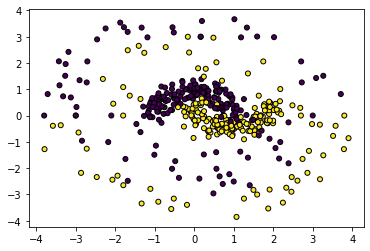

In [25]:
from sklearn.datasets import make_moons

N = 300
X1, y1 = make_moons(n_samples=N, noise=0.2)

X2 = []
y2 = []
for radius in np.linspace(1.5, 3, 6):
    for angle in np.linspace(0, np.pi, 30):
        if np.random.rand() < 0.2:
            X2.append([radius*np.cos(angle), radius*np.sin(angle)])
            y2.append(1)
    for angle in np.linspace(np.pi, 2*np.pi, 30):
        if np.random.rand() < 0.2:
            X2.append([radius*np.cos(angle), radius*np.sin(angle)])
            y2.append(0)

for radius in np.linspace(3, 4, 6):
    for angle in np.linspace(0, np.pi, 30):
        if np.random.rand() < 0.2:
            X2.append([radius*np.cos(angle), radius*np.sin(angle)])
            y2.append(0)
    for angle in np.linspace(np.pi, 2*np.pi, 30):
        if np.random.rand() < 0.2:
            X2.append([radius*np.cos(angle), radius*np.sin(angle)])
            y2.append(1)

X2 = np.array(X2)
X = np.concatenate([X1, X2])
Y = np.concatenate([y1, y2])

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, s=25, edgecolor='k')
print(X.shape, Y.shape)

In [26]:
xTrain, yTrain, xTest, yTest = shuffleSplit(X, Y)
optimalParams = scipy.optimize.minimize(computeNegLogMarginal, [1, 1], args=(xTrain, yTrain), bounds=((10**(-3), None), (10**(-3), None))) 

print('Initial params: rho = 1, l = 1')
print('Negative Log Marginal Likelihood with initial params = {}'.format(computeNegLogMarginal([1, 1], xTrain, yTrain)))
print('Optimized params: rho = {}, l = {}'.format(optimalParams.x[0], optimalParams.x[1]))
print('Negative Log Marginal Likelihood with optimized params = {}'.format(computeNegLogMarginal(optimalParams.x, xTrain, yTrain)))

rho, l = optimalParams.x
K = getKernel(rho, l, xTrain)
gpPrior = getPrior(K)

# Compute posterior with initial hyperparameters
initK = getKernel(1, 1, xTrain)
initPosteriorMean, initPosteriorSigma = getPosteriorEfficient(initK, yTrain)

# Compute posterior for optimized hyperparameters
gpPosteriorMean, gpPosteriorSigma = getPosteriorEfficient(K, yTrain)

xs = np.linspace(-4, 4, 40)
ys = np.linspace(-4, 4, 40)
grid = np.array([[i, j] for i in xs for j in ys])
preds = getPosteriorPredictiveEfficient(grid, gpPosteriorMean, xTrain, yTrain, K, rho, l)

Initial params: rho = 1, l = 1
Negative Log Marginal Likelihood with initial params = 177.37439288626254
Optimized params: rho = 14.467389000896004, l = 0.7220557557684243
Negative Log Marginal Likelihood with optimized params = 98.38924129369335


Text(0.5, 1.0, 'Contour plot of Mean of GP Posterior (default hyperparams)')

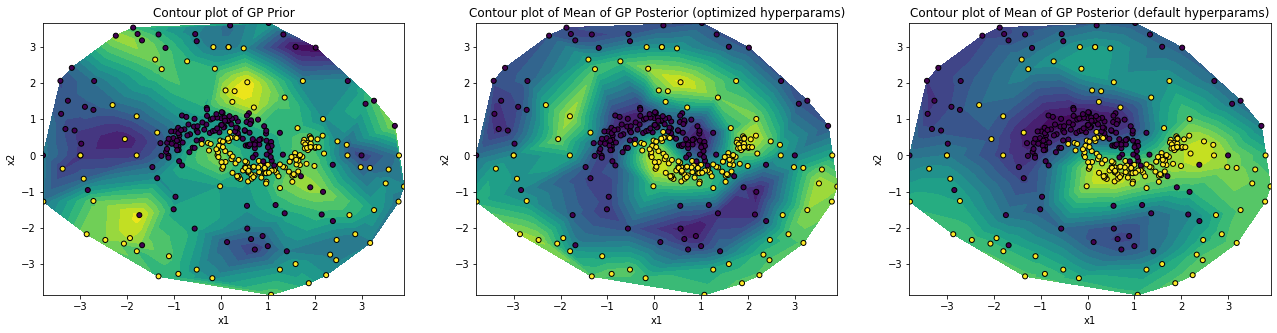

In [27]:
fig = plt.figure(figsize=(22, 5))
plt.subplot(131)
plt.tricontourf(xTrain[:, 0], xTrain[:, 1], gpPrior, levels=15)
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=25, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot of GP Prior')

plt.subplot(132)
plt.tricontourf(xTrain[:, 0], xTrain[:, 1], gpPosteriorMean, levels=15)
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=25, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot of Mean of GP Posterior (optimized hyperparams)')

plt.subplot(133)
plt.tricontourf(xTrain[:, 0], xTrain[:, 1], initPosteriorMean, levels=15)
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=25, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour plot of Mean of GP Posterior (default hyperparams)')

Performance on Test Set: 83 points classified correctly out of 88 total points



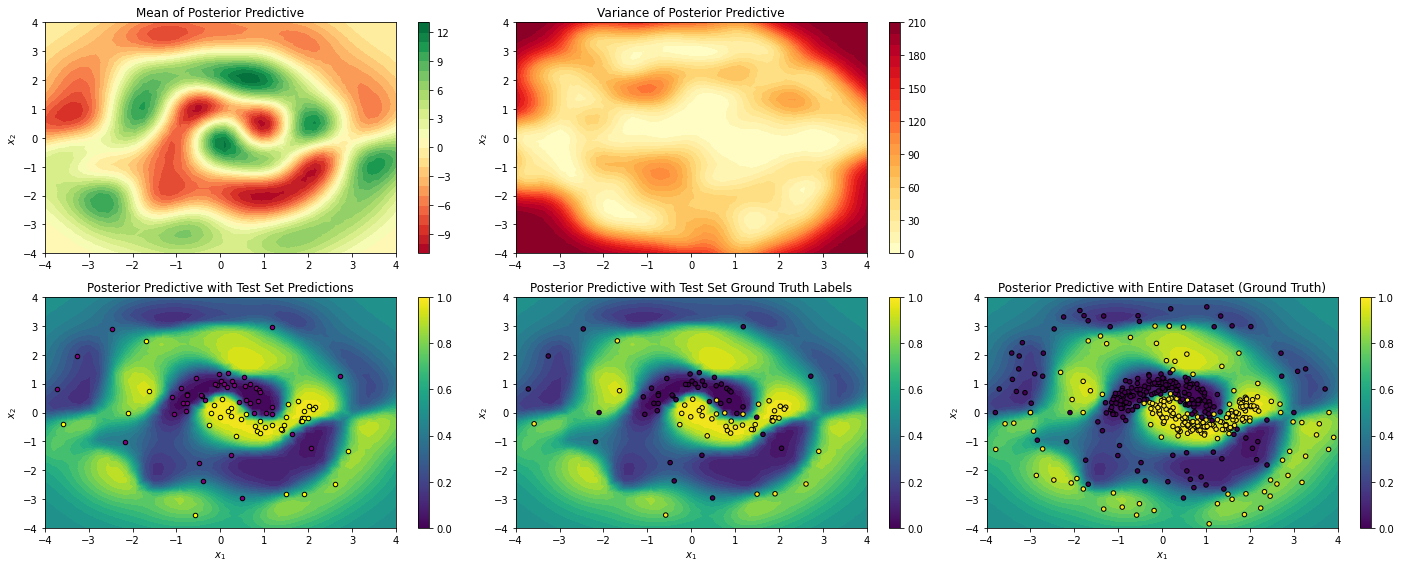

In [28]:
plt.figure(figsize=(20, 8))

plt.subplot(231)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 0], levels=25, cmap='RdYlGn')
boundary = grid[np.where((preds[:, 2] > 0.46) & (preds[:, 2] < 0.55))]
plt.colorbar()
plt.title('Mean of Posterior Predictive')
plt.ylabel('$x_2$')

plt.subplot(232)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 1], levels=25, cmap='YlOrRd')
plt.colorbar()
plt.title('Variance of Posterior Predictive')
plt.ylabel('$x_2$')

plt.subplot(234)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 2], levels=25)
testPreds = getPosteriorPredictiveEfficient(xTest, gpPosteriorMean, xTrain, yTrain, K, rho, l)
numCorrect = 0
for i in range(len(testPreds)):
    if testPreds[i, 2] > 0.5:
        plt.scatter(xTest[i, 0], xTest[i, 1], marker='o', c='yellow', s=20, edgecolor='k')
        if yTest[i] == 1:
            numCorrect += 1
    else:
        plt.scatter(xTest[i, 0], xTest[i, 1], marker='o', c='purple', s=20, edgecolor='k')
        if yTest[i] == 0:
            numCorrect += 1

print('Performance on Test Set: {} points classified correctly out of {} total points\n'.format(numCorrect, yTest.shape[0]))

plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Posterior Predictive with Test Set Predictions')

plt.subplot(235)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 2], levels=25)
plt.scatter(xTest[:, 0], xTest[:, 1], marker='o', c=yTest, s=20, edgecolor='k')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Posterior Predictive with Test Set Ground Truth Labels')

plt.subplot(236)
plt.tricontourf(grid[:, 0], grid[:, 1], preds[:, 2], levels=25)
plt.scatter(xTest[:, 0], xTest[:, 1], marker='o', c=yTest, s=20, edgecolor='k')
plt.scatter(xTrain[:, 0], xTrain[:, 1], marker='o', c=yTrain, s=20, edgecolor='k')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Posterior Predictive with Entire Dataset (Ground Truth)')

plt.tight_layout()

Overall, the model is able to capture the nonlinear decision boundaries fairly well in the harder dataset. The variance plot also gives us an understanding of where we can collect more data in order to improve accuracy of predictions